In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production solaire** :

* SARIMAX avec des données métier en régresseurs exogènes
* SARIMAX sur le signal sans régresseur
* Régression linéaire sur les données métiers comme variables explicatives

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_W.csv',
                usecols = ['Dates', 'Solaire'])
df.head(1)

,Dates,Solaire
0,2013-01-06,172.982639


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_solaire_FR.csv',
                  usecols = ['Dates', 'Capa_sol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('W').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_sol'] = df['Solaire'] / df['Capa_sol']
df

,Solaire,Capa_sol,TCH_sol
Dates,,,
2013-01-06,172.982639,3648.500000,0.047412
2013-01-13,166.345238,3660.428571,0.045444
2013-01-20,138.241071,3673.285714,0.037634
2013-01-27,207.166667,3685.571429,0.056210
2013-02-03,261.723214,3697.142857,0.070791
...,...,...,...
2021-10-03,1632.187500,12239.142857,0.133358
2021-10-10,1839.604167,12290.857143,0.149673
2021-10-17,2037.178571,12341.857143,0.165063


''

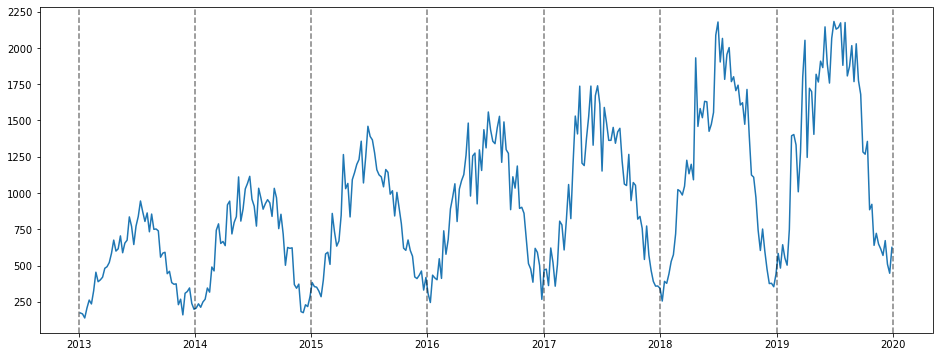

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Solaire'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

''

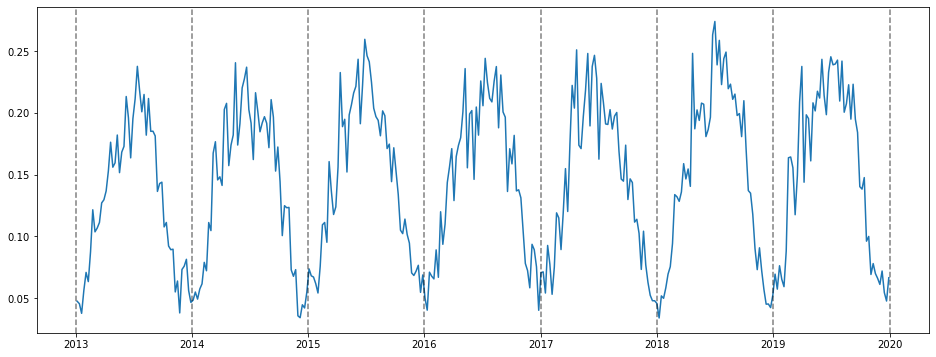

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_sol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_sol'])

(-8.679087044450263,
 4.335049574623238e-14,
 15,
 445,
 {'1%': -3.4451307246616514,
  '5%': -2.86805689169311,
  '10%': -2.570241263729327},
 -2033.257906102674)

### Coéfficients SARIMAX et saisonnalités

C:\Python\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


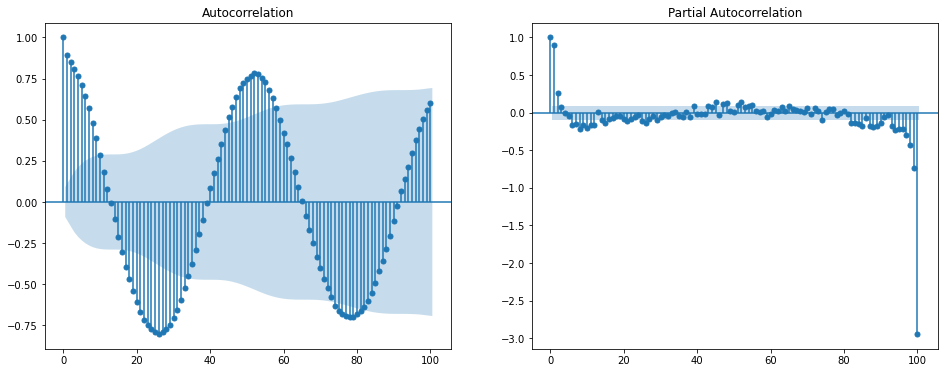

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_sol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_sol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
fenetre = df_test.shape[0]

In [14]:
indice = df_test.index

In [15]:
bilan = df_test

# Paramètres SARIMAX

In [16]:
ordre = (2,0,0)
saison = (1,0,0,52)

# Régresseurs exogènes : données métier

In [17]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-06,8.102778


In [18]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [20]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [21]:
result_exog = model_exog.fit(low_memory=True)

In [22]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 848.751
Date:                            Wed, 04 May 2022   AIC                          -1687.501
Time:                                    10:31:23   BIC                          -1668.002
Sample:                                         0   HQIC                         -1679.752
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.000     31.970      0.000       0.012       0.013
ar.L1          0.4745      0.052      9.157      0.000       0.373       0.576
ar.L2          0.2295      0.052      4.386      0.000       0.127       0.332
ar.S.L52       0.1719      0.061      2.838      0.005       0.053       0.291
sigma2         0.0006   4.12e-05     13.504      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                10.34
Prob(Q):                              0.60   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                             0.32
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [23]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [24]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Sol_p_exog'])

In [25]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [26]:
bilan['Err_exog'] = np.abs(bilan['Sol_p_exog'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_exog,Err_exog
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1569.574405,10516.144345,0.148280,0.145591,0.023231
std,656.829974,898.979610,0.059780,0.049108,0.016917
min,450.732143,9417.571429,0.044104,0.058798,0.000262
25%,959.880952,9791.214286,0.097386,0.100636,0.011247
50%,1668.544643,10164.214286,0.160262,0.156816,0.019163
75%,2129.639137,11224.357143,0.197115,0.183921,0.032472
max,2705.217262,12445.142857,0.261755,0.227080,0.079075


# Sans régresseur

### SARIMAX

In [27]:
model_noreg = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [28]:
result_noreg = model_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [29]:
result_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 813.238
Date:                            Wed, 04 May 2022   AIC                          -1618.476
Time:                                    10:31:25   BIC                          -1602.877
Sample:                                         0   HQIC                         -1612.277
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6807      0.050     13.619      0.000       0.583       0.779
ar.L2          0.3089      0.050      6.192      0.000       0.211       0.407
ar.S.L52       0.1777      0.055      3.228      0.001       0.070       0.286
sigma2         0.0007   4.96e-05     13.497      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                11.63
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.17
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [30]:
predict_noreg = result_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [31]:
predict_noreg = pd.DataFrame(predict_noreg, index = indice, columns = ['Sol_p_noreg'])

In [32]:
bilan = pd.concat([bilan, predict_noreg], axis = 1)

### Erreur absolue

In [33]:
bilan['Err_noreg'] = np.abs(bilan['Sol_p_noreg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_exog,Err_exog,Sol_p_noreg,Err_noreg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1569.574405,10516.144345,0.148280,0.145591,0.023231,0.140744,0.024344
std,656.829974,898.979610,0.059780,0.049108,0.016917,0.055719,0.019212
min,450.732143,9417.571429,0.044104,0.058798,0.000262,0.039763,0.000523
25%,959.880952,9791.214286,0.097386,0.100636,0.011247,0.094990,0.008830
50%,1668.544643,10164.214286,0.160262,0.156816,0.019163,0.152784,0.020996
75%,2129.639137,11224.357143,0.197115,0.183921,0.032472,0.190231,0.032521
max,2705.217262,12445.142857,0.261755,0.227080,0.079075,0.235836,0.092046


# Régression linéaire avec Régresseurs exogènes : données métier 

In [34]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-06,8.102778


In [35]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [36]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [37]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_sol'])
predict_lr = LinReg.predict(exog_test)

In [38]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Sol_p_LinReg'])

In [39]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_LinReg'] = np.abs(bilan['Sol_p_LinReg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_exog,Err_exog,Sol_p_noreg,Err_noreg,Sol_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1569.574405,10516.144345,0.148280,0.145591,0.023231,0.140744,0.024344,0.151971,0.020952
std,656.829974,898.979610,0.059780,0.049108,0.016917,0.055719,0.019212,0.056437,0.014143
min,450.732143,9417.571429,0.044104,0.058798,0.000262,0.039763,0.000523,0.059300,0.000260
25%,959.880952,9791.214286,0.097386,0.100636,0.011247,0.094990,0.008830,0.103859,0.011605
50%,1668.544643,10164.214286,0.160262,0.156816,0.019163,0.152784,0.020996,0.155317,0.018333
75%,2129.639137,11224.357143,0.197115,0.183921,0.032472,0.190231,0.032521,0.204051,0.033780
max,2705.217262,12445.142857,0.261755,0.227080,0.079075,0.235836,0.092046,0.230065,0.049066


# Calcul de la prediction : TCH x Capacité

In [41]:
bilan['Sol_p_exog'] = bilan['Sol_p_exog'] * bilan['Capa_sol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_sol']
bilan['Sol_p_noreg'] = bilan['Sol_p_noreg'] * bilan['Capa_sol']
bilan['Err_noreg'] = bilan['Err_noreg'] * bilan['Capa_sol']
bilan['Sol_p_LinReg'] = bilan['Sol_p_LinReg'] * bilan['Capa_sol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_sol']
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_exog,Err_exog,Sol_p_noreg,Err_noreg,Sol_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1569.574405,10516.144345,0.148280,1543.375618,244.281690,1497.472825,255.108224,1608.775573,221.889923
std,656.829974,898.979610,0.059780,563.923690,177.502097,636.762845,199.198033,631.642266,153.129663
min,450.732143,9417.571429,0.044104,596.295670,3.082101,375.761296,5.892646,577.733277,2.946973
25%,959.880952,9791.214286,0.097386,1036.478678,120.510523,958.633275,98.102178,1056.580012,116.540455
50%,1668.544643,10164.214286,0.160262,1691.707785,194.369365,1574.320541,228.772098,1636.704611,194.563264
75%,2129.639137,11224.357143,0.197115,1992.027778,335.459699,2008.181864,347.601227,2153.270747,339.463495
max,2705.217262,12445.142857,0.261755,2604.214153,770.857901,2704.632939,897.302333,2650.450530,603.566181


# Visualisation réel vs prédictions

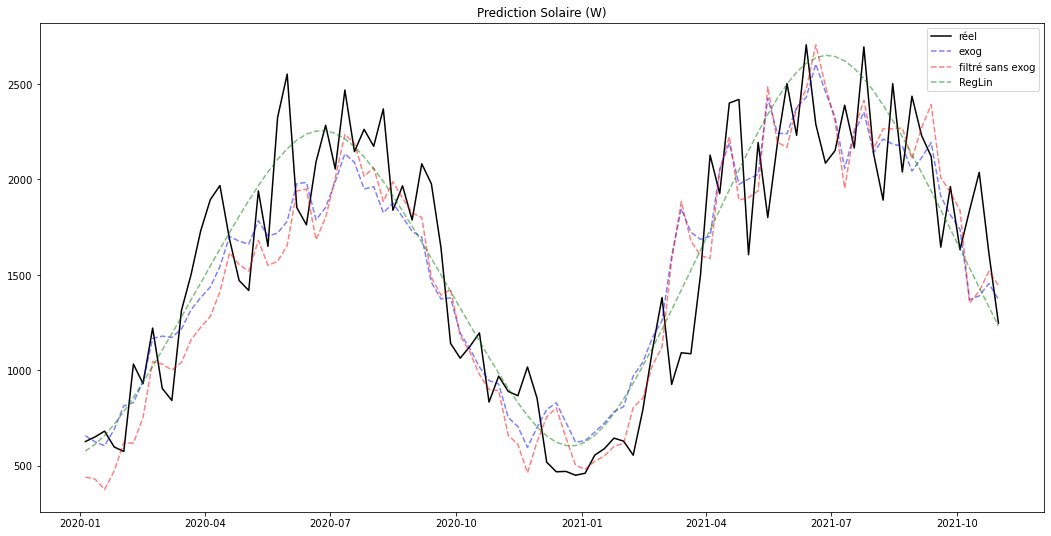

In [42]:
plt.figure(figsize=(18,9))
#plt.plot(df_train['Solaire'].resample('W').mean(), color = 'k')
plt.plot(bilan['Solaire'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Sol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Sol_p_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Sol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.legend(loc = 'upper right')
plt.title('Prediction Solaire (W)')
plt.savefig('./results/pred_solaire_W.png');

# Synthèse des erreurs

In [43]:
erreur = bilan[['Err_exog',
       'Err_noreg',
       'Err_LinReg'
      ]].describe()
erreur

,Err_exog,Err_noreg,Err_LinReg
count,96.000000,96.000000,96.000000
mean,244.281690,255.108224,221.889923
std,177.502097,199.198033,153.129663
min,3.082101,5.892646,2.946973
25%,120.510523,98.102178,116.540455
50%,194.369365,228.772098,194.563264
75%,335.459699,347.601227,339.463495
max,770.857901,897.302333,603.566181


In [44]:
bilan.to_csv('./results/bilan_solaire_W.csv', sep = ';')
erreur.to_csv('./results/erreur_solaire_W.csv', sep = ';')